In [1]:
## Import libraries
import os, sys
from IPython.utils import io
from IPython.display import clear_output
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn

source = "../source"
sys.path.append(source)

from compilation import Compiler, ScalarTracker, ActivationTracker
import publication
import models
import simulate
import two_points

device = torch.device("cpu")

plot_path = "plots/2_points/comparisons/"

publication.set_color_mixed(1)

/tmp/ipykernel_4947/1140881546.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
settings = pd.read_csv("model_settings/2 points.txt", sep=" ", header=0)

In [3]:
def make_plots(setting):
    ## Load settings
    (
        model_type,
        nonlinearity,
        gain,
        lr,
        P,
        L,
        n_epochs,
        hidden_layer,
        dx2,
        dy2,
        in_dim,
        out_dim,
    ) = settings.loc[setting].to_numpy()
    model_type = getattr(models, model_type)
    if nonlinearity == "discontinuous":
        nonlinearity = simulate.Discontinuous.apply
    elif nonlinearity == "none":
        nonlinearity = None
    else:
        nonlinearity = getattr(torch.nn.functional, nonlinearity)

    threshold = 1e-4
    n_epochs_plot = 40000

    figsize = (2, 2)

    ## Load data
    def load_data(data_name):
        data_path = f"{plot_path}{data_name}.pkl"
        if os.path.exists(data_path):
            with open(data_path, "rb") as f:
                return pickle.load(f)
        else:
            return {}

    etas_h_dic, etas_y_dic = load_data("etas_h"), load_data("etas_y")

    if setting in etas_h_dic.keys():
        eta_h_opts = etas_h_dic[setting]
        eta_y_opts = etas_y_dic[setting]
        print("Fit parameters succesfully loaded from previous run.")
    else:
        ## Fit effective learning rates
        print("Could not find previous fit parameters, fitting...")
        eta_h_opts, eta_y_opts = [], []
        for _ in range(50):
            data, encoding = two_points.data_set(dx2, dy2, 1, 1, device)

            model = model_type(
                encoding=encoding,
                input_size=1,
                output_size=1,
                hidden_dim=P,
                n_hid_layers=L,
                device=device,
                init_std=gain,
                non_linearity=nonlinearity,
            )

            ## Setup compiler
            criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
            optimizer = torch.optim.SGD(model.parameters(), lr=lr / 2)
            compiler = Compiler(model, criterion, optimizer)
            compiler.trackers = {
                "loss": ScalarTracker(lambda: compiler.validation([data])),
                "hidden": ActivationTracker(
                    model,
                    lambda inputs: model(inputs)[1][hidden_layer],
                    datasets=[data],
                ),
                "output": ActivationTracker(
                    model, lambda inputs: model(inputs)[0], datasets=[data]
                ),
            }

            ## Get initial values
            h0, y0, w0 = two_points.get_h_y_w(data, model, hidden_layer)

            ## Training run
            with io.capture_output() as captured:
                compiler.training_run(
                    [data], [data], n_epochs=2 * n_epochs, batch_size=100
                )

            ## Discard trials which did not converge
            if compiler.trackers["loss"].get_entry(-1)[0][0] > 1e-2:
                continue

            ## Get data
            data_hid = compiler.trackers["hidden"].get_trace().copy()
            data_output = compiler.trackers["output"].get_trace().copy()
            h_A = [
                np.array(data.loc[epoch, 0, "A"])
                for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
            ]
            h_B = [
                np.array(data.loc[epoch, 0, "B"])
                for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
            ]
            y_A = [
                np.array(data.loc[epoch, 0, "A"])
                for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
            ]
            y_B = [
                np.array(data.loc[epoch, 0, "B"])
                for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
            ]
            epochs = np.arange(0, len(h_A))
            y_true_A, y_true_B = data[0][1].numpy(), data[1][1].numpy()
            dy2 = np.sum((y_true_B - y_true_A) ** 2)
            h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])
            y2 = np.array([np.sum((y_A[epoch] - y_B[epoch]) ** 2) for epoch in epochs])
            w = np.array(
                [
                    y2[epoch] - np.dot(y_true_A - y_true_B, y_A[epoch] - y_B[epoch])
                    for epoch in epochs
                ]
            )

            ## Find etas
            eta_h_opt, eta_y_opt, fit_loss = simulate.optimize_eta(h2, y2, w, dx2, dy2)
            eta_h_opts.append(eta_h_opt)
            eta_y_opts.append(eta_y_opt)

        ## Save data
        etas_h_dic[setting] = eta_h_opts
        etas_y_dic[setting] = eta_y_opts
        with open(f"{plot_path}etas_h.pkl", "wb") as f:
            pickle.dump(etas_h_dic, f)
        with open(f"{plot_path}etas_y.pkl", "wb") as f:
            pickle.dump(etas_y_dic, f)

    eta_h, eta_y = np.mean(eta_h_opts), np.mean(eta_y_opts)

    print(f"eta_h, eta_y = {eta_h}, {eta_y}")

    h0s, y0s, w0s, hs, ys, ws = [], [], [], [], [], []
    dx2s, dy2s = [], []

    N = 5
    m = 1

    print("Computing comparison...")
    for dx in np.linspace(0.5, 1.5, N):
        for dy in np.linspace(0, 1, N):
            dx2 = dx**2
            dy2 = dy**2
            variables = []
            for _ in range(m):
                ## Generate data
                data, encoding = two_points.data_set(dx2, dy2, 1, 1, device)

                ## Instantiate model
                model = model_type(
                    encoding=encoding,
                    input_size=1,
                    output_size=1,
                    hidden_dim=P,
                    n_hid_layers=L,
                    device=device,
                    init_std=gain,
                    non_linearity=nonlinearity,
                )

                ## Setup compiler
                criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
                optimizer = torch.optim.SGD(model.parameters(), lr=lr / 5)
                compiler = Compiler(model, criterion, optimizer)
                compiler.trackers = {
                    "loss": ScalarTracker(lambda: compiler.validation([data]))
                }

                ## Get initial values
                h0, y0, w0 = two_points.get_h_y_w(data, model, hidden_layer)

                ## Training run
                with io.capture_output() as captured:
                    compiler.training_run(
                        [data],
                        [],
                        n_epochs=n_epochs_plot,
                        batch_size=100,
                        conv_thresh=threshold,
                    )

                ## Discard trials which did not converge
                if compiler.trackers["loss"].get_entry(-1)[0][0] > 1e-3:
                    break

                ## Get final values
                h, y, w = two_points.get_h_y_w(data, model, hidden_layer)

                variables.append([h0, y0, w0, h, y, w])

            if len(variables) > 0:
                variables = np.mean(np.array(variables), axis=0)
                for i, array in enumerate((h0s, y0s, w0s, hs, ys, ws)):
                    array.append(variables[i])
                dx2s.append(dx2)
                dy2s.append(dy2)

                clear_output(wait=True)

                ## Plot
                publication.set_color_mixed()
                A_low = np.sqrt(eta_h / eta_y) * np.sqrt(dy2s) * np.sqrt(dx2s)
                A_high = (
                    np.array(h0s) / np.array(dx2s)
                    - np.array(y0s) / np.array(h0s) * eta_h / eta_y
                ) * np.array(dx2s)
                h_theory = 0.5 * A_high + np.sqrt(0.25 * A_high**2 + A_low**2)
                fig = plt.figure(figsize=figsize)
                plt.scatter(h_theory, hs)
                plt.xlabel("$||dh(\infty)||^2$ (Theory)")
                plt.ylabel("$||dh(\infty)||^2$ (Experiment)")
                plt.ylim(0, 1.1 * max(hs))
                plt.xlim(0)
                plt.scatter(-1, -1)
                plt.plot(
                    np.sort(h_theory),
                    np.sort(h_theory),
                    linestyle="--",
                    color="0.6",
                    zorder=0,
                )
                publication.plt_show(
                    save_path=plot_path + setting + ".png",
                )

    return

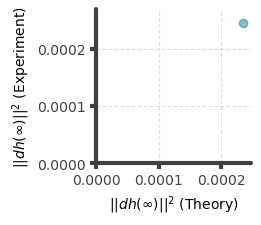

KeyboardInterrupt: 

In [4]:
etas_h, etas_y = {}, {}
for setting in settings.index:
    print(f"\t\t\t\t\t-----{setting.upper()}-----")
    make_plots(setting)